In [1]:
import itertools
import pickle
import numpy as np
import pandas as pd

from music21 import *
from matplotlib import pyplot as plt
from sklearn import svm, naive_bayes, neighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from seaborn import heatmap
from seaborn.cm import rocket_r


from modules.clfobj import Clfobj
import modules.data_loader as loader

In [2]:
def fit(x_train,y_train, x_test, y_test,classifiers):
    for clf in classifiers:
        clf.fit(x_train,y_train)
        print(clf)
        print(f"acc: {clf.score(x_test,y_test)}","\n")

In [3]:
def find_k(x_train,y_train, x_test, y_test):
    best_acc = 0
    k = 0
    for i in range(1,30):
        k_nn = neighbors.KNeighborsClassifier(n_neighbors=i)
        k_nn.fit(x_train, y_train)
        acc = k_nn.score(x_test,y_test)
        if(acc>best_acc):
            best_acc = acc
            k = i
    print(f"best k = {k}, best acc = {best_acc}")
    return k

In [4]:
def fit_ngrams(x_train,y_train,x_test,y_test,n):    
    ngrams_train, ngrams_test = ngrams_vectorize(x_train, x_test,n)
    
    k = find_k(ngrams_train,y_train,ngrams_test,y_test)
    fit(ngrams_train,y_train,ngrams_test,y_test,
         [neighbors.KNeighborsClassifier(n_neighbors=k), naive_bayes.MultinomialNB(),svm.LinearSVC(dual=False)])
    

In [5]:
def ngrams_vectorize(x_train,x_test,n):
    print("n =",n)
    
    ngram_vectorizer = CountVectorizer(token_pattern="\d+", ngram_range=(1, n))
    ngrams_train = ngram_vectorizer.fit_transform(x_train)
    ngrams_test = ngram_vectorizer.transform(x_test)

    print("train shape =", ngrams_train.shape)
    print("test shape =", ngrams_test.shape)
    
    return ngrams_train, ngrams_test

In [6]:
def combine(x1,x2,x1_classes):
    result =[]
    for a,b in zip (x1,x2):
        result.append(x1_classes * b + a)
    return result

In [7]:
def combine_item(x1,x2,x1_classes):
    return x1_classes * x2 + x1

In [8]:
def unique_dict(in_list):
    dic = dict.fromkeys(in_list)
    for i,k in enumerate(dic.keys()):
        dic[k]=i
    return dic

In [9]:
def values_to_labels(in_list,dic):
    out_list = [dic[x] for x in in_list]
    return out_list        

In [10]:
def stringify_items(in_list):
    return [str(x) for x in in_list]

In [11]:
# Define known chords
chords_list = ([0], [0,4,7],[0,3,7],[0,5,7],[0,4,8],[0,3,6],[0,4,7,9],[0,3,7,9],
[0,4,7,10],[0,4,7,11],[0,3,7,10],[0,3,6,10],[0,3,6,9],[0,2,4,7,11],
[0,2,4,7,10],[0,1,4,7,10],[0,2,3,7,10])

# chord_types_list = [tone,major, minor, suspended, augmented, 
#                     diminished, major_sixth, minor_sixth, 
#                     dominant_seventh, major_seventh, 
#                     minor_seventh, half_diminished_seventh, 
#                     diminished_seventh, major_ninth, 
#                     dominant_ninth, dominant_minor_ninth, minor_ninth]

In [12]:
def find_chord(in_list):
    root = in_list[0]
    if(len(in_list)==1):
        return root
    costs = []
    for chord in chords_list:
        cost = 0
        for tone_p, tone_ch in itertools.zip_longest(in_list[1:],chord):
            if(tone_p == None or tone_ch == None):
                cost += 3
            else:
                cost+= abs(tone_p - tone_ch)
        costs.append(cost)
    i = list.index(costs,min(costs))
    return combine_item(root,i,12)
        

In [13]:
def annotate(confusion_mtx):
    annot=[]
    for i,row in enumerate(confusion_mtx):
        row_data = []
        row_sum = sum(row)
        for j,col in enumerate(row):
            percent = (col/sum(row))*100
            s=""
            colstr=col
            if i==j:
                colstr = f"{col}/{row_sum}"
            if col != 0:
                s = f"{percent:.2f}%\n {colstr}"
            row_data.append(s)
        annot.append(row_data)
    annot=np.matrix(annot)
    return annot
    

## Loading data

In [14]:
%%capture
composerNames = ["debussy","scarlatti","mozart","victoria","beethoven","haydn","handel"]
dataset_type = "chords_t"
x_train_ch, x_test_ch,y_train, y_test = loader.load(dataset_type,composerNames)

In [15]:
lens =[]
for i,comp in enumerate(composerNames):
    lens.append([len(example) for example,y in zip(x_train_ch,y_train) if y==i])
    
df = pd.DataFrame(lens)
df=df.transpose()
df.columns=composerNames
df.describe()

,debussy,scarlatti,mozart,victoria,beethoven,haydn,handel
count,119.000000,443.000000,423.000000,188.000000,380.000000,402.000000,380.000000
mean,2598.857143,1144.349887,4366.028369,1286.659574,6752.355263,1840.196517,1635.563158
std,3130.408684,406.723100,4103.791556,673.145066,6075.072023,1271.186890,1474.055880
min,369.000000,375.000000,414.000000,451.000000,479.000000,22.000000,25.000000
25%,948.500000,869.500000,1441.500000,767.750000,2219.750000,899.750000,611.000000
50%,1505.000000,1081.000000,3153.000000,1094.000000,4728.000000,1588.000000,1198.000000
75%,2434.000000,1328.500000,5826.500000,1620.750000,9111.000000,2486.250000,2080.000000
max,18528.000000,3346.000000,26675.000000,3315.000000,29833.000000,6077.000000,6768.000000


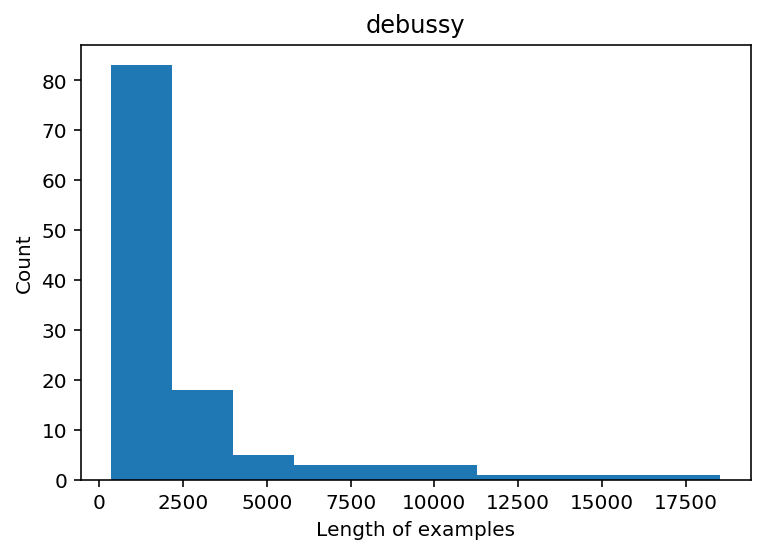

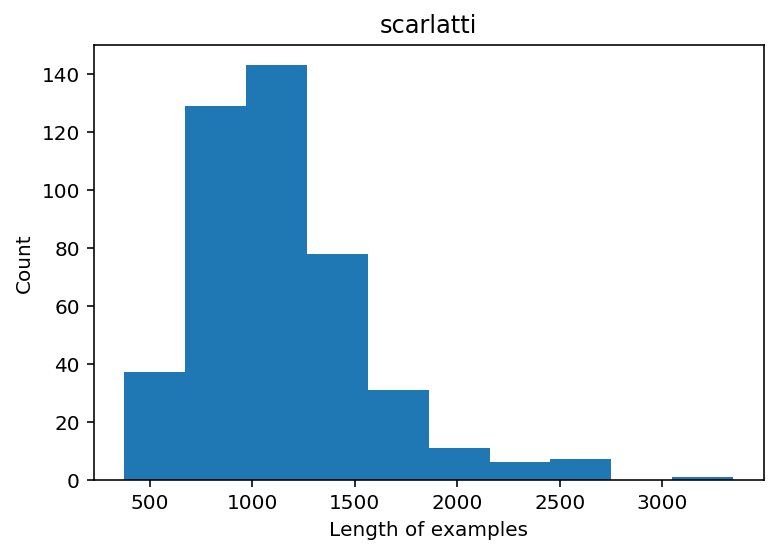

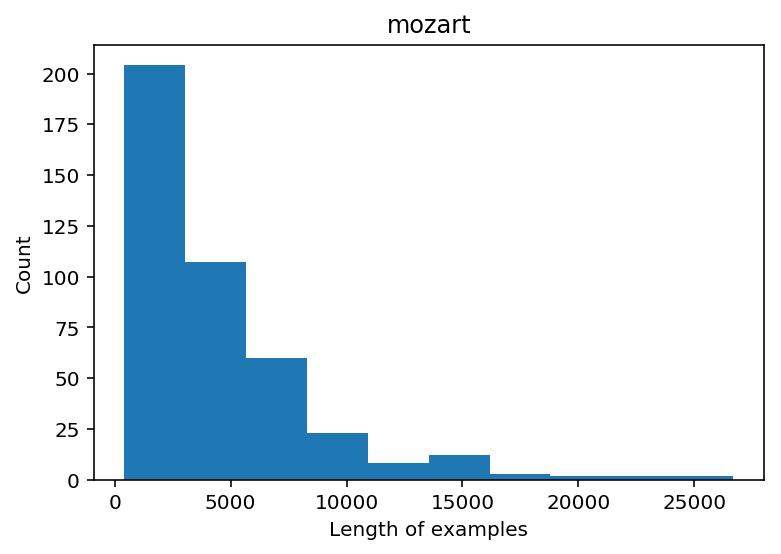

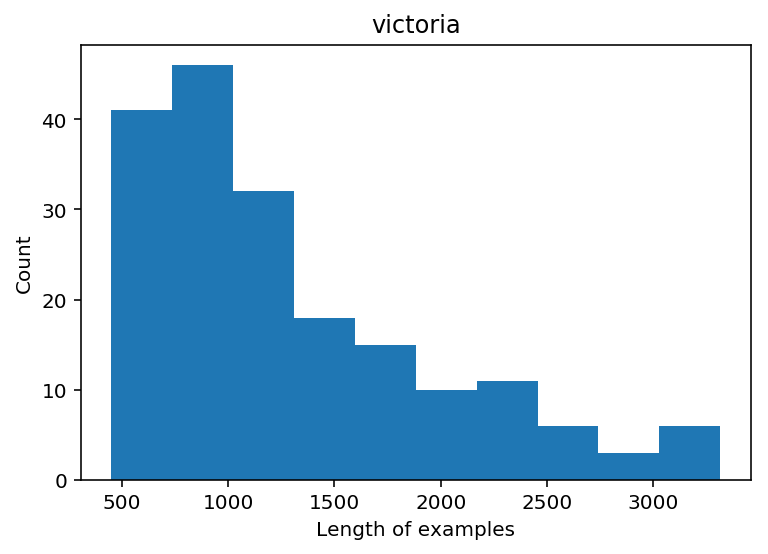

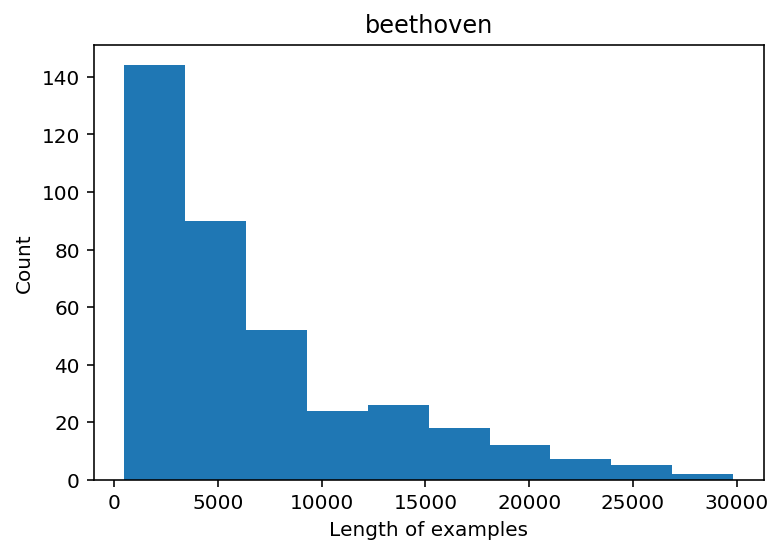

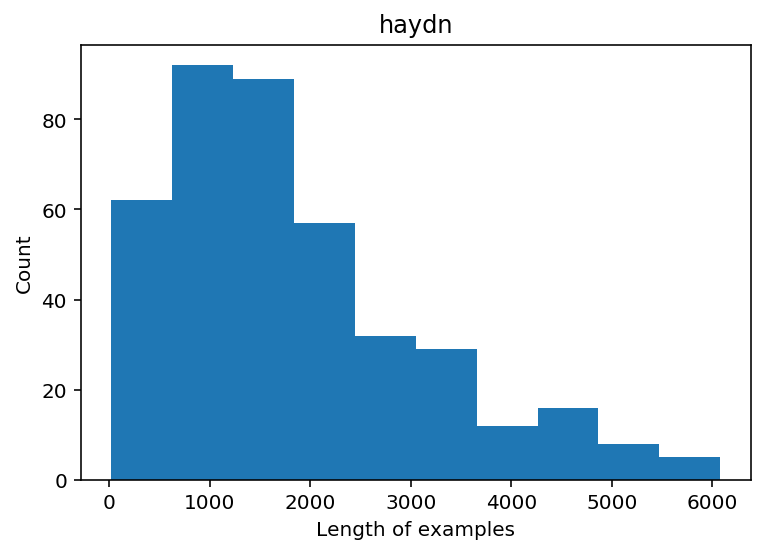

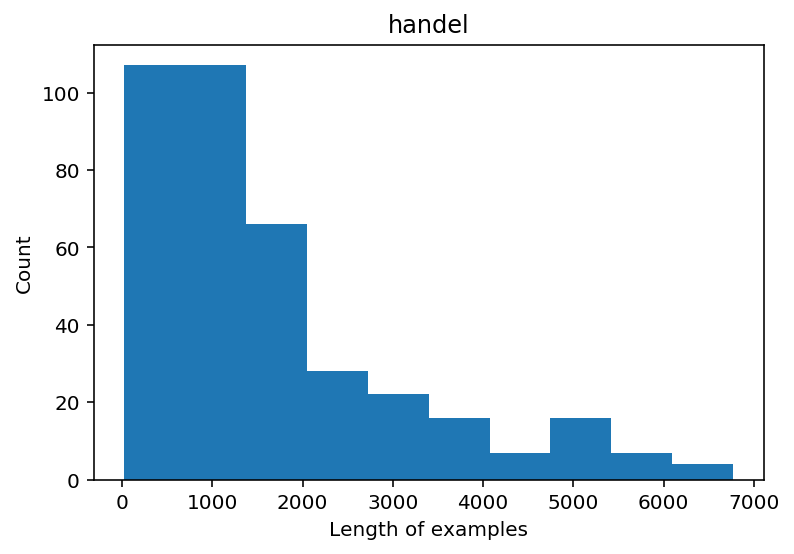

In [16]:
# the histogram of the data
for i,comp in enumerate(composerNames):
    plt.hist(lens[i])
    plt.xlabel("Length of examples")
    plt.ylabel("Count")
    plt.title(comp)
    plt.show()

In [17]:
counts = [loader.get_data_counts(y_train,composerNames),loader.get_data_counts(y_test,composerNames)]
pd.DataFrame(counts,index=["train","test"])

,beethoven,debussy,handel,haydn,mozart,scarlatti,victoria
train,380,119,380,402,423,443,188
test,61,40,129,145,124,147,61


In [18]:
x_train = [str([chord[0] for chord in example ]) for example in x_train_ch]
x_test = [str([chord[0] for chord in example]) for example in x_test_ch]

In [19]:
# x_train_d, x_test_d,y_train, y_test = loader.load("durations",composerNames)

In [20]:
# x_train = [str([find_chord(chord) for chord in example ]) for example in x_train_ch]
# x_test = [str([find_chord(chord) for chord in example])for example in x_test_ch]

In [21]:
# pitches_seq = list(itertools.chain.from_iterable(x_train_ch+x_test_ch))
# pitches_dict = unique_dict(pitches_seq)

# x_train_ch = [values_to_labels(example,pitches_dict) for example in x_train_ch]
# x_test_ch = [values_to_labels(example,pitches_dict) for example in x_test_ch]

# durations_seq = list(itertools.chain.from_iterable(x_train_d+x_test_d))
# durations_dict = unique_dict(durations_seq)

# x_train_d = [values_to_labels(example,durations_dict) for example in x_train_d]
# x_test_d = [values_to_labels(example,durations_dict) for example in x_test_d]

In [22]:
# x_train = list(map(str, combine(x_train_ch,x_train_d,len(pitches_dict))))
# x_test = list(map(str, combine(x_test_ch,x_test_d,len(pitches_dict))))

# Benchmarking models

In [52]:
x_train,y_train = loader.shuffle_data(x_train,y_train)
x_test,y_test = loader.shuffle_data(x_test,y_test)

for n in range(1,5):
    fit_ngrams(x_train,y_train,x_test,y_test,n)

n = 1
train shape = (5778, 12)
test shape = (1190, 12)
best k = 1, best acc = 0.6546218487394958
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
acc: 0.6546218487394958 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
acc: 0.3840336134453782 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
acc: 0.48403361344537815 

n = 2
train shape = (5778, 156)
test shape = (1190, 156)
best k = 1, best acc = 0.7218487394957983
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
acc: 0.7218487394957983 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
acc: 0.48403361344537815 

LinearSVC(

# Training a model

In [25]:
ngram_vectorizer = CountVectorizer(token_pattern="\d+", ngram_range=(1, 2))
ngrams_train = ngram_vectorizer.fit_transform(x_train)
ngrams_test = ngram_vectorizer.transform(x_test)

print("train shape =", ngrams_train.shape)
print("test shape =", ngrams_test.shape)

clf = neighbors.KNeighborsClassifier(n_neighbors=1)
fit(ngrams_train, y_train,ngrams_test,y_test,[clf])


train shape = (2335, 156)
test shape = (707, 156)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')
acc: 0.6916548797736917 



# Plotting a confusion matrix

Text(69.0, 0.5, 'Actual')

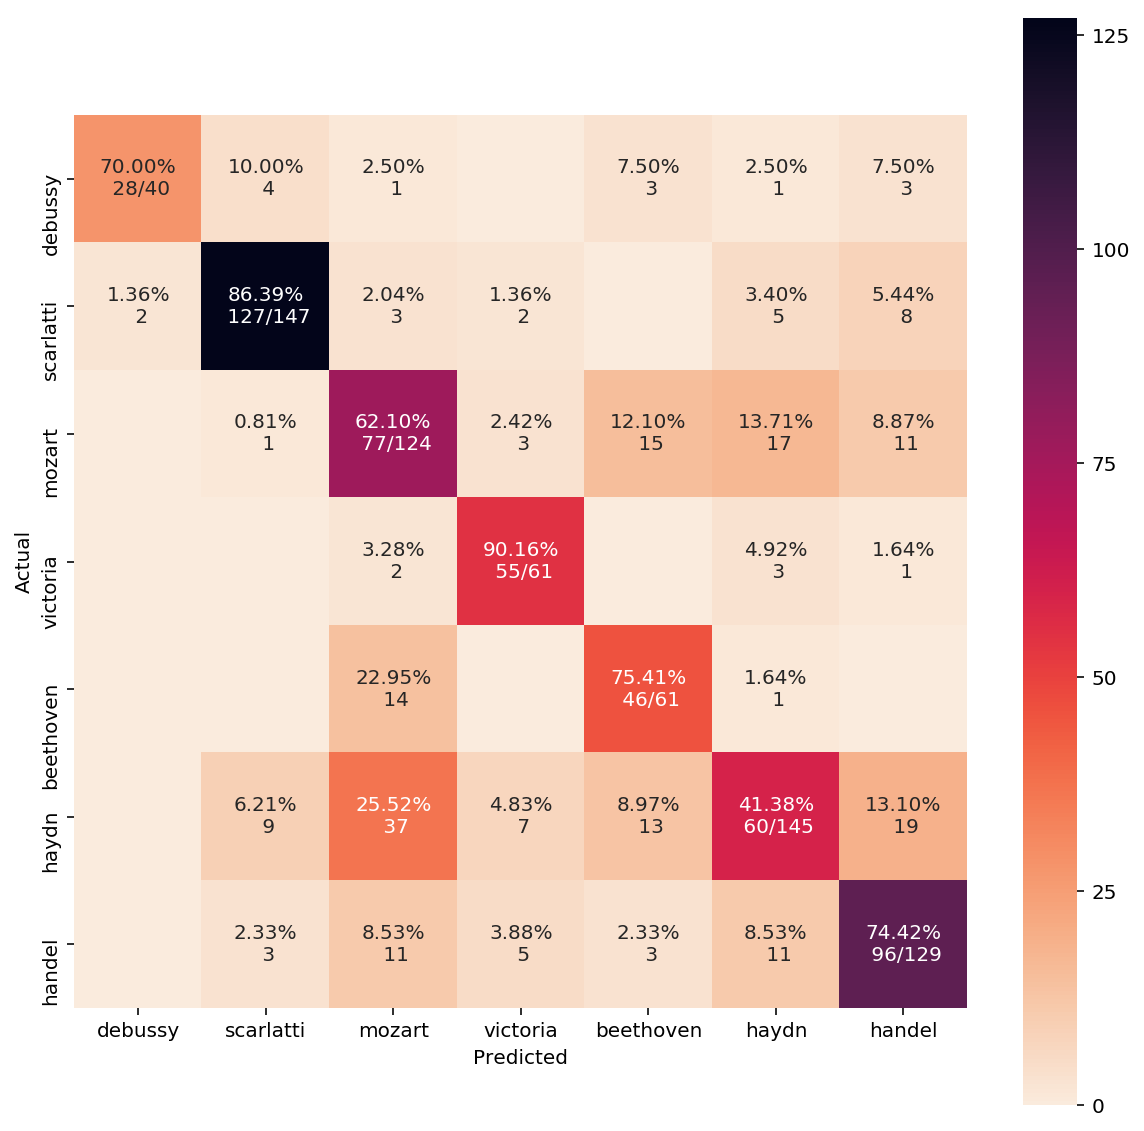

In [26]:
# Predict the values from the validation dataset
y_pred = clf.predict(ngrams_test)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)
annot = annotate(confusion_mtx)
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
ax = heatmap(data=confusion_mtx,annot=annot,square=True,
        xticklabels=composerNames, yticklabels=composerNames,fmt="",cmap=rocket_r)

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

In [28]:
pd.DataFrame(classification_report(y_test, y_pred, target_names=composerNames, output_dict=True))

,debussy,scarlatti,mozart,victoria,beethoven,haydn,handel,micro avg,macro avg,weighted avg
f1-score,0.800000,0.872852,0.572491,0.827068,0.652482,0.493827,0.719101,0.691655,0.705403,0.687298
precision,0.933333,0.881944,0.531034,0.763889,0.575000,0.612245,0.695652,0.691655,0.713300,0.697333
recall,0.700000,0.863946,0.620968,0.901639,0.754098,0.413793,0.744186,0.691655,0.714090,0.691655
support,40.000000,147.000000,124.000000,61.000000,61.000000,145.000000,129.000000,707.000000,707.000000,707.000000


# Saving a model

In [29]:
obj = Clfobj(clf,composerNames,ngram_vectorizer, "chords_t",loader.get_root)
with open("classifiers/knn_2grams.dat","wb") as f:
    pickle.dump(obj,f)